<a href="https://colab.research.google.com/github/Amirhatamian/ML-/blob/main/PERCOLATION_ON_BOOLEAN_NETWORKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-c4919462730d>:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_components)


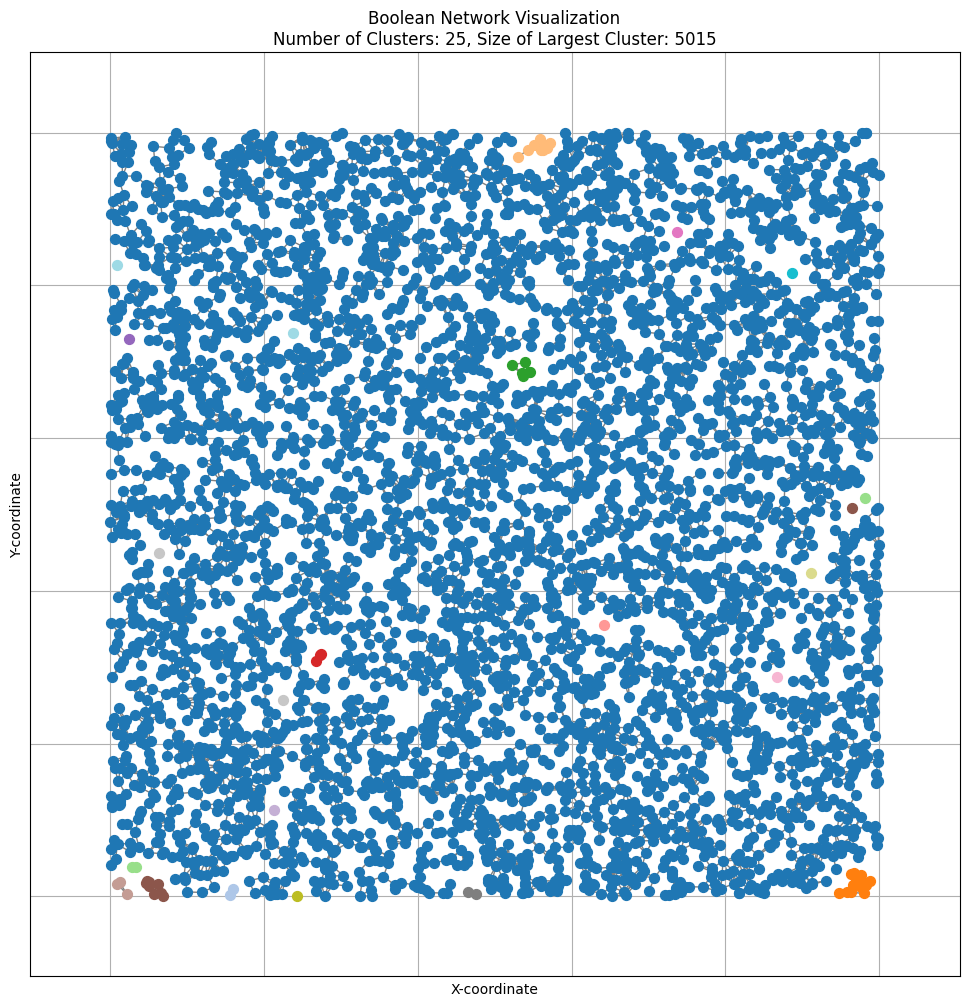

Simulating for λ=0.100: 100%|██████████| 100/100 [00:02<00:00, 38.14it/s]


λ = 0.100, Avg Largest Cluster Size = 13.530


Simulating for λ=0.133: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


λ = 0.133, Avg Largest Cluster Size = 20.570


Simulating for λ=0.165: 100%|██████████| 100/100 [00:04<00:00, 24.17it/s]


λ = 0.165, Avg Largest Cluster Size = 32.560


Simulating for λ=0.198: 100%|██████████| 100/100 [00:03<00:00, 29.06it/s]


λ = 0.198, Avg Largest Cluster Size = 51.390


Simulating for λ=0.230: 100%|██████████| 100/100 [00:02<00:00, 49.97it/s]


λ = 0.230, Avg Largest Cluster Size = 86.480


Simulating for λ=0.263: 100%|██████████| 100/100 [00:02<00:00, 41.42it/s]


λ = 0.263, Avg Largest Cluster Size = 153.650


Simulating for λ=0.295: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


λ = 0.295, Avg Largest Cluster Size = 317.470


Simulating for λ=0.328: 100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


λ = 0.328, Avg Largest Cluster Size = 748.910


Simulating for λ=0.360: 100%|██████████| 100/100 [00:06<00:00, 15.28it/s]


λ = 0.360, Avg Largest Cluster Size = 1834.370


Simulating for λ=0.393: 100%|██████████| 100/100 [00:07<00:00, 13.98it/s]


λ = 0.393, Avg Largest Cluster Size = 3144.380


Simulating for λ=0.425: 100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


λ = 0.425, Avg Largest Cluster Size = 3910.780


Simulating for λ=0.458: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


λ = 0.458, Avg Largest Cluster Size = 4403.000


Simulating for λ=0.490: 100%|██████████| 100/100 [00:07<00:00, 13.83it/s]


λ = 0.490, Avg Largest Cluster Size = 4813.260


Simulating for λ=0.523: 100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


λ = 0.523, Avg Largest Cluster Size = 5171.620


Simulating for λ=0.555: 100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


λ = 0.555, Avg Largest Cluster Size = 5507.370


Simulating for λ=0.588: 100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


λ = 0.588, Avg Largest Cluster Size = 5865.760


Simulating for λ=0.621: 100%|██████████| 100/100 [00:11<00:00,  8.35it/s]


λ = 0.621, Avg Largest Cluster Size = 6184.830


Simulating for λ=0.653: 100%|██████████| 100/100 [00:12<00:00,  8.27it/s]


λ = 0.653, Avg Largest Cluster Size = 6524.270


Simulating for λ=0.686: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


λ = 0.686, Avg Largest Cluster Size = 6848.350


Simulating for λ=0.718: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


λ = 0.718, Avg Largest Cluster Size = 7177.110


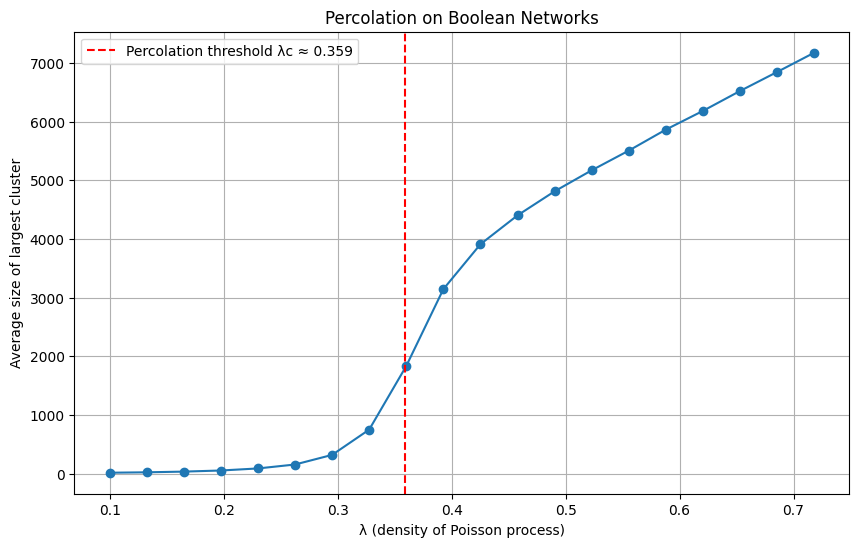

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import networkx as nx
from tqdm import tqdm
import itertools


def generate_poisson_points(lambda_density, T):
    """
    Generate points in a square domain using a Poisson process.

    Parameters:
    lambda_density (float): Density of the Poisson process.
    T (float): Size of the square domain.

    Returns:
    numpy.ndarray: Array of points.
    """
    N = np.random.poisson(lambda_density * T**2)
    points = np.random.uniform(0, T, (N, 2))
    return points

def create_boolean_network(points, r):
    """
    Create a Boolean network using a k-d tree for efficient neighbor search.

    Parameters:
    points (numpy.ndarray): Array of points.
    r (float): Radius for connectivity.

    Returns:
    networkx.Graph: Graph representing the Boolean network.
    """
    tree = KDTree(points)
    pairs = tree.query_pairs(2 * r)
    G = nx.Graph()
    for i, point in enumerate(points):
        G.add_node(i, pos=point)
    G.add_edges_from(pairs)
    return G


def show_graph(G):
    pos = nx.get_node_attributes(G, 'pos')

    # Identify connected components and color them
    components = list(nx.connected_components(G))
    largest_component_size = max(len(c) for c in components)
    num_components = len(components)

    # Generate unique colors for each component
    colors = plt.cm.get_cmap('tab20', num_components)

    plt.figure(figsize=(12, 12))
    for i, component in enumerate(components):
        nx.draw_networkx_nodes(G, pos, nodelist=component, node_size=50, node_color=[colors(i)])
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in itertools.combinations(component, 2) if G.has_edge(u, v)], edge_color='grey')

    plt.title(f'Boolean Network Visualization\nNumber of Clusters: {num_components}, Size of Largest Cluster: {largest_component_size}')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()

# Example usage
lambda_density = 0.5  # Density of the Poisson process
T = 100               # Size of the square domain
r = 1                 # Radius for connectivity

# Generate points
points = generate_poisson_points(lambda_density, T)

# Create the Boolean network
G = create_boolean_network(points, r)

# Visualize the graph
show_graph(G)

def get_largest_cluster_size(G):
    """
    Identify the size of the largest cluster using BFS.

    Parameters:
    G (networkx.Graph): Graph representing the Boolean network.

    Returns:
    int: Size of the largest cluster.
    """
    clusters = list(nx.connected_components(G))
    largest_cluster = max(clusters, key=len)
    return len(largest_cluster)

def simulate_networks(lambda_density, T, r, M):
    """
    Simulate multiple Boolean networks and compute the average size of the largest cluster.

    Parameters:
    lambda_density (float): Density of the Poisson process.
    T (float): Size of the square domain.
    r (float): Radius for connectivity.
    M (int): Number of simulations.

    Returns:
    float: Average size of the largest cluster.
    """
    largest_clusters = []
    for _ in tqdm(range(M), desc=f'Simulating for λ={lambda_density:.3f}'):
        points = generate_poisson_points(lambda_density, T)
        G = create_boolean_network(points, r)
        largest_cluster_size = get_largest_cluster_size(G)
        largest_clusters.append(largest_cluster_size)
    return np.mean(largest_clusters)

def plot_results(lambdas, largest_cluster_sizes, lambda_c):
    """
    Plot the results of the simulation.

    Parameters:
    lambdas (list): List of lambda values.
    largest_cluster_sizes (list): List of average largest cluster sizes.
    lambda_c (float): Percolation threshold.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(lambdas, largest_cluster_sizes, marker='o')
    plt.axvline(x=lambda_c, color='r', linestyle='--', label=f'Percolation threshold λc ≈ {lambda_c:.3f}')
    plt.xlabel('λ (density of Poisson process)')
    plt.ylabel('Average size of largest cluster')
    plt.title('Percolation on Boolean Networks')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    """
    Main function to run the project.
    """
    T = 100  # Size of the squared domain
    r = 1    # Radius for connectivity
    M = 100  # Number of simulations
    lambda_c = 4.512 / (4 * np.pi)  # Critical lambda value

    lambdas = np.linspace(0.1, 2 * lambda_c, 20)
    largest_cluster_sizes = []

    for lambda_density in lambdas:
        avg_largest_cluster_size = simulate_networks(lambda_density, T, r, M)
        largest_cluster_sizes.append(avg_largest_cluster_size)
        print(f'λ = {lambda_density:.3f}, Avg Largest Cluster Size = {avg_largest_cluster_size:.3f}')

    plot_results(lambdas, largest_cluster_sizes, lambda_c)

if __name__ == "__main__":
    main()


Simulating λ=0.718: 100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


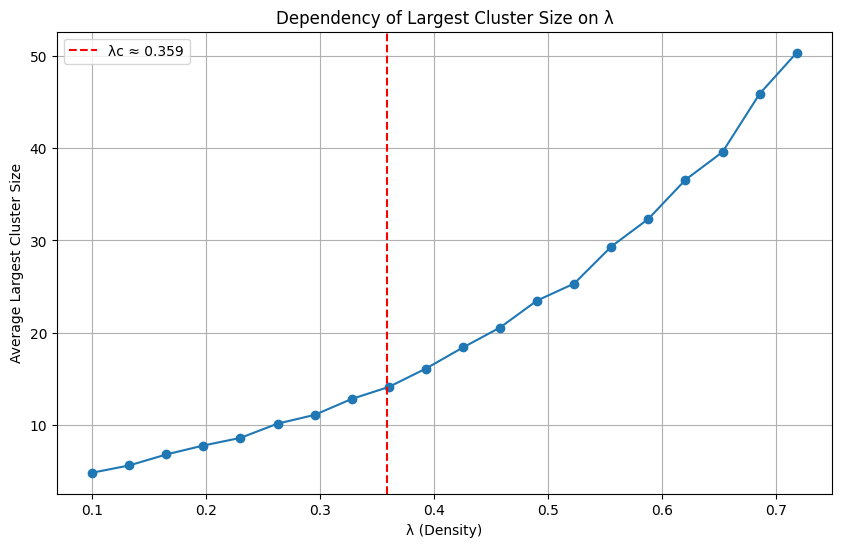

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import networkx as nx
from tqdm import tqdm
import itertools

def generate_poisson_points(lambda_density, T):
    """
    Simulate a Poisson process to generate points within a square domain.
    """
    N = np.random.poisson(lambda_density * T**2)
    return np.random.uniform(0, T, (N, 2))

def create_boolean_network(points, r):
    """
    Use a KDTree for efficient radius-based neighbor search to construct the network.
    """
    tree = KDTree(points)
    edges = tree.query_pairs(r)def show_graph(G):
    pos = nx.get_node_attributes(G, 'pos')

    # Identify connected components and color them
    components = list(nx.connected_components(G))
    largest_component_size = max(len(c) for c in components)
    num_components = len(components)

    # Generate unique colors for each component
    colors = plt.cm.get_cmap('tab20', num_components)

    plt.figure(figsize=(12, 12))
    for i, component in enumerate(components):
        nx.draw_networkx_nodes(G, pos, nodelist=component, node_size=50, node_color=[colors(i)])
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in itertools.combinations(component, 2) if G.has_edge(u, v)], edge_color='grey')

    plt.title(f'Boolean Network Visualization\nNumber of Clusters: {num_components}, Size of Largest Cluster: {largest_component_size}')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()

    # Example usage
lambda_density = 0.5  # Density of the Poisson process
T = 100               # Size of the square domain
r = 1                 # Radius for connectivity

# Generate points
points = generate_poisson_points(lambda_density, T)

# Create the Boolean network
G = create_boolean_network(points, r)

# Visualize the graph
show_graph(G)
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    G.add_edges_from(edges)
    return G



    """
    Use a KDTree for efficient radius-based neighbor search to construct the network.
    """
    tree = KDTree(points)
    edges = tree.query_pairs(r)
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    G.add_edges_from(edges)
    # Add position as node attribute for visualization
    for i, point in enumerate(points):
        G.nodes[i]['pos'] = point
    return G

def show_graph(G):
    # This line was not indented correctly, causing the error.
    pos = nx.get_node_attributes(G, 'pos')

    # Identify connected components and color them
    components = list(nx.connected_components(G))
    largest_component_size = max(len(c) for c in components)
    num_components = len(components)

    # Generate unique colors for each component
    colors = plt.cm.get_cmap('tab20', num_components)

    plt.figure(figsize=(12, 12))
    for i, component in enumerate(components):
        nx.draw_networkx_nodes(G, pos, nodelist=component, node_size=50, node_color=[colors(i)])
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in itertools.combinations(component, 2) if G.has_edge(u, v)], edge_color='grey')

    plt.title(f'Boolean Network Visualization\nNumber of Clusters: {num_components}, Size of Largest Cluster: {largest_component_size}')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()


def bfs_largest_cluster(G):
    """
    Use BFS to find the largest cluster in the network.
    """
    largest_cluster_size = 0
    visited = [False] * len(G.nodes)
    for node in G.nodes:
        if not visited[node]:
            size = 0
            queue = [node]
            while queue:
                current = queue.pop(0)
                if not visited[current]:
                    visited[current] = True
                    size += 1
                    queue.extend(n for n in G.neighbors(current) if not visited[n])
            largest_cluster_size = max(largest_cluster_size, size)
    return largest_cluster_size

def simulate_networks(lambda_density, T, r, M):
    """
    Simulate multiple networks to compute the empirical average size of the largest cluster.
    """
    cluster_sizes = []
    for _ in tqdm(range(M), desc=f'Simulating λ={lambda_density:.3f}'):
        points = generate_poisson_points(lambda_density, T)
        G = create_boolean_network(points, r)
        cluster_size = bfs_largest_cluster(G)
        cluster_sizes.append(cluster_size)
    return np.mean(cluster_sizes)

def plot_results(lambdas, cluster_sizes, lambda_c):
    """
    Plot the dependency of the largest cluster size on λ.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(lambdas, cluster_sizes, marker='o')
    plt.axvline(x=lambda_c, color='r', linestyle='--', label=f'λc ≈ {lambda_c:.3f}')
    plt.xlabel('λ (Density)')
    plt.ylabel('Average Largest Cluster Size')
    plt.title('Dependency of Largest Cluster Size on λ')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    T = 100  # Size of the square domain
    r = 1    # Connectivity radius
    M = 100  # Number of simulations
    lambda_c = 4.512 / (4 * np.pi)  # Percolation threshold
    lambdas = np.linspace(0.1, 2 * lambda_c, 20)
    results = [simulate_networks(ld, T, r, M) for ld in lambdas]
    plot_results(lambdas, results, lambda_c)

if __name__ == "__main__":
    main()


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import networkx as nx
from tqdm import tqdm
import itertools

def generate_poisson_points(lambda_density, T):
    """
    Simulate a Poisson process to generate points within a square domain.
    """
    N = np.random.poisson(lambda_density * T**2)
    return np.random.uniform(0, T, (N, 2))


def create_boolean_network(points, r):
    """
    Create a Boolean network using a k-d tree for efficient neighbor search.

    Parameters:
    points (numpy.ndarray): Array of points.
    r (float): Radius for connectivity.

    Returns:
    networkx.Graph: Graph representing the Boolean network.
    """
    tree = KDTree(points)
    pairs = tree.query_pairs(2 * r)
    G = nx.Graph()
    for i, point in enumerate(points):
        G.add_node(i, pos=point)
    G.add_edges_from(pairs)
    return G

<ipython-input-9-049f63f43547>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_components)


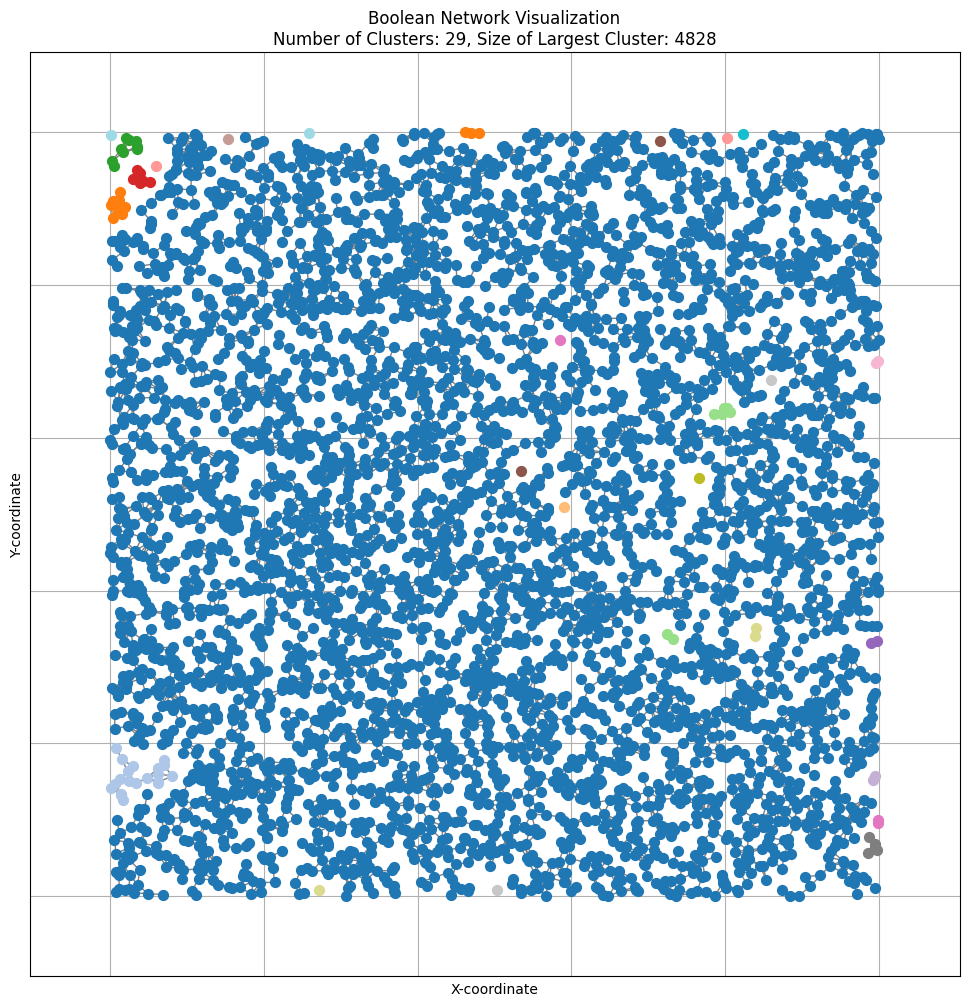

In [9]:
def show_graph(G):
    pos = nx.get_node_attributes(G, 'pos')

    # Identify connected components and color them
    components = list(nx.connected_components(G))
    largest_component_size = max(len(c) for c in components)
    num_components = len(components)

    # Generate unique colors for each component
    colors = plt.cm.get_cmap('tab20', num_components)

    plt.figure(figsize=(12, 12))
    for i, component in enumerate(components):
        nx.draw_networkx_nodes(G, pos, nodelist=component, node_size=50, node_color=[colors(i)])
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v in itertools.combinations(component, 2) if G.has_edge(u, v)], edge_color='grey')

    plt.title(f'Boolean Network Visualization\nNumber of Clusters: {num_components}, Size of Largest Cluster: {largest_component_size}')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()

    # Example usage
lambda_density = 0.5  # Density of the Poisson process
T = 100               # Size of the square domain
r = 1                 # Radius for connectivity

# Generate points
points = generate_poisson_points(lambda_density, T)

# Create the Boolean network
G = create_boolean_network(points, r)

# Visualize the graph
show_graph(G)

In [11]:
def bfs_largest_cluster(G):
    """
    Use BFS to find the largest cluster in the network.
    """
    largest_cluster_size = 0
    visited = [False] * len(G.nodes)
    for node in G.nodes:
        if not visited[node]:
            size = 0
            queue = [node]
            while queue:
                current = queue.pop(0)
                if not visited[current]:
                    visited[current] = True
                    size += 1
                    queue.extend(n for n in G.neighbors(current) if not visited[n])
            largest_cluster_size = max(largest_cluster_size, size)
    return largest_cluster_size

def simulate_networks(lambda_density, T, r, M):
    """
    Simulate multiple networks to compute the empirical average size of the largest cluster.
    """
    cluster_sizes = []
    for _ in tqdm(range(M), desc=f'Simulating λ={lambda_density:.3f}'):
        points = generate_poisson_points(lambda_density, T)
        G = create_boolean_network(points, r)
        cluster_size = bfs_largest_cluster(G)
        cluster_sizes.append(cluster_size)
    return np.mean(cluster_sizes)


Simulating λ=0.718: 100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


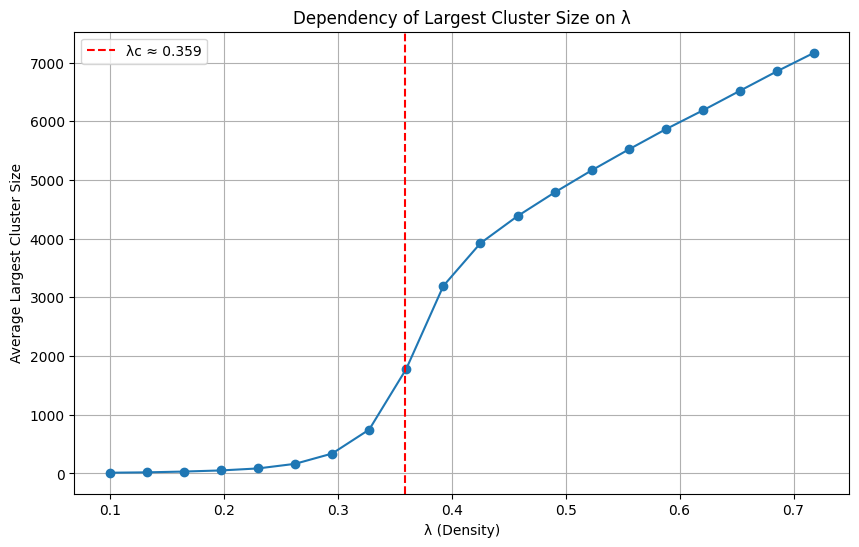

In [12]:
def plot_results(lambdas, cluster_sizes, lambda_c):
    """
    Plot the dependency of the largest cluster size on λ.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(lambdas, cluster_sizes, marker='o')
    plt.axvline(x=lambda_c, color='r', linestyle='--', label=f'λc ≈ {lambda_c:.3f}')
    plt.xlabel('λ (Density)')
    plt.ylabel('Average Largest Cluster Size')
    plt.title('Dependency of Largest Cluster Size on λ')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    T = 100  # Size of the square domain
    r = 1    # Connectivity radius
    M = 100  # Number of simulations
    lambda_c = 4.512 / (4 * np.pi)  # Percolation threshold
    lambdas = np.linspace(0.1, 2 * lambda_c, 20)
    results = [simulate_networks(ld, T, r, M) for ld in lambdas]
    plot_results(lambdas, results, lambda_c)

if __name__ == "__main__":
    main()